Links
* [kaldi paper](https://www.danielpovey.com/files/2014_icassp_pitch.pdf)
* [wantee](http://wantee.github.io/2015/03/14/feature-extraction-for-asr-pitch/)
* [rapt](https://www.ee.columbia.edu/~dpwe/papers/Talkin95-rapt.pdf)
* [jiao, zhimi, chaocheng](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6375195)
* [online viterbi](http://www.dcs.fmph.uniba.sk/diplomovky/obhajene/getfile.php/main.pdf?id=143&fid=289&type=application%2Fpdf) and [here](https://pdfs.semanticscholar.org/fbd5/a448a6cd59e7af8a213edae98a3703459eb0.pdf)
* [lvhang](https://github.com/LvHang/pitch/tree/master/src)

In [274]:
import math
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchaudio

In [349]:
# Voice sound
# dataset = torchaudio.datasets.YESNO("~/yesno")
# waveform = dataset[0][0]
# sample_rate = 8 * 10**3

# Train sound
# filename = "_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"

# filename = "Audio_Sample_-_The_Quick_Brown_Fox_Jumps_Over_The_Lazy_Dog.wav"
# filename = "from_research_to_production.wav"
# filename = "research_to_prod_2.wav"
filename = "To-be-or-not-to-be-Kenneth-Branagh-HD-HAMLET-AudioTrimmer.com.wav"
# filename = "A4.wav"
# filename = "440Hz_44100Hz_16bit_05sec.wav"
# filename = "100Hz_44100Hz_16bit_05sec.wav"
# filename = "333713__hammondman__a4.wav"
filename
waveform, sample_rate = torchaudio.load(filename)
# waveform = torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=16000)(waveform)
# sample_rate = 16000

# Convert to mono
waveform = waveform.mean(0).view(1,-1)

# plt.plot(waveform.t())

In [276]:
waveform.shape

torch.Size([1, 663023])

In [277]:
waveform.size()

torch.Size([1, 663023])

In [278]:
sample_rate

44100

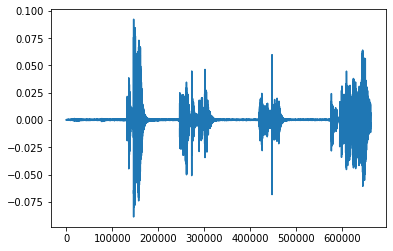

In [279]:
plt.plot(waveform.t())

In [280]:
# w = torch.arange(100, dtype=torch.float64) + 1
# w = torch.randn(100)

In [350]:
# https://en.wikipedia.org/wiki/Voice_frequency
# Usable voice frequencies for telephony: 30-3400 Hz
# Fundamental Frequency: 85-180 Hz or 165-255 Hz

lags = math.ceil(sample_rate/85)  # Around 500 samples

frame_time = 10**-2
frame_size = int(math.ceil(sample_rate*frame_time))
EPSILON = 10**(-9)

w = waveform.view(-1)
waveform_length = w.size()[-1]
num_of_frames = math.ceil(waveform_length/frame_size)

# num_of_frames = math.ceil((lags+waveform_length)/frame_size)
# num_of_frames_floor = math.floor(waveform_length/frame_size)

p = lags + num_of_frames * frame_size - waveform_length
w = torch.nn.functional.pad(w, (0, p))

# get lags
output_lag = []
for lag in range(1,lags+1):
    s1 = w[:-lag].unfold(0, frame_size, frame_size)[:num_of_frames,:]
    s2 = w[lag:].unfold(0, frame_size, frame_size)[:num_of_frames,:]
    
    # print(s1)
    # print(s1.size(), s2.size())
    # print((s1*s2).size())
    # break
    
    output_frames = (s1*s2).sum(-1)/(EPSILON + s1.norm(dim=-1))/(EPSILON + s2.norm(dim=-1))
    # print(output_frames.size())
    
    output_lag.append(output_frames.view(-1,1))

r2 = torch.cat(output_lag, 1)

print(r2.shape)
print(r2.abs().max())

torch.Size([1504, 519])
tensor(0.9997)


In [282]:
# [t.size() for t in output_lag]

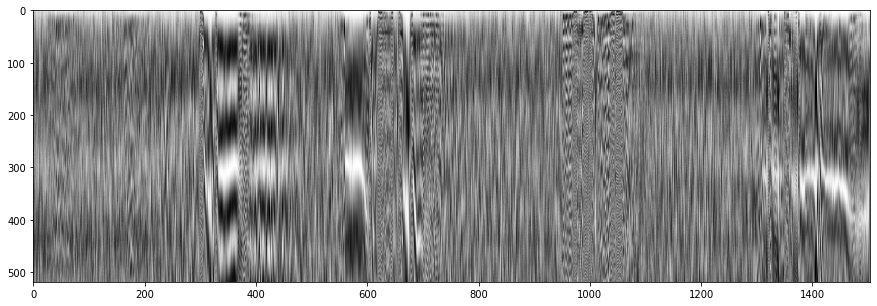

In [351]:
# correllograms

plt.figure(figsize=(15,5))
plt.imshow(r2.t(), cmap="gray", aspect="auto")

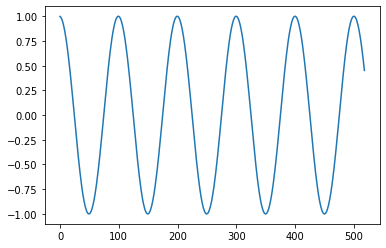

In [346]:
plt.plot(r2[50])

13


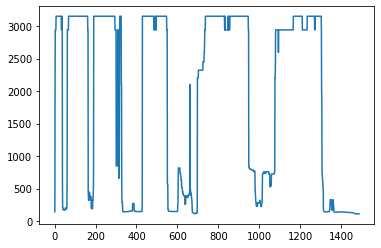

In [356]:
EPSILON = 10**(-9)

# https://en.wikipedia.org/wiki/Voice_frequency
# Usable voice frequencies for telephony: 30-3400 Hz
# Fundamental Frequency: 85-180 Hz or 165-255 Hz

smoothing_window = 30  # in units of frames
# smoothing_window = 50  # in units of frames

# Voice frequency is no shorter
lag_min = math.ceil(sample_rate/3400)  # Around 10 samples
print(lag_min)

# Find max

half = torch.max(r2[:,lag_min:r2.shape[-1]//2], -1)
quarter = torch.max(r2[:,lag_min:r2.shape[-1]//4], -1)
best = torch.max(r2[:,lag_min:], -1)


def combine_max(a, b):
    thresh = 0.99
    mask = (a[0] > thresh * b[0]).to(int)
    values = mask * a[0] + (1-mask) * b[0]
    indices = mask * a[1] + (1-mask) * b[1]
    return values, indices

# print(best[1])

# best = combine_max(half, best)
# best = combine_max(quarter, best)

_, indices = best

# Add back minimal lag
# Add 1 empirical calibration offset
indices += lag_min + 1

# print(indices)

# Median smoothing
# indices = torch.nn.functional.pad(indices, (smoothing_window-1,0), mode="constant", value=indices[0])  # Online
indices = torch.nn.functional.pad(indices, ((smoothing_window-1)//2,0), mode="constant", value=indices[0])  # Centered
roll = indices.unfold(0, smoothing_window, 1)
values, _ = torch.median(roll, -1)
freq = sample_rate/(EPSILON + values.to(torch.float))

plt.plot(freq)
# plt.plot((float(sample_rate)/values.type(torch.DoubleTensor).log()))

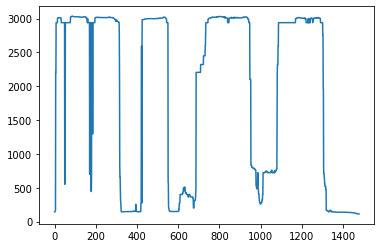

In [298]:
m = freq[10:].abs().max()
freq = torch.clamp(freq, -m,m)
plt.plot(freq)

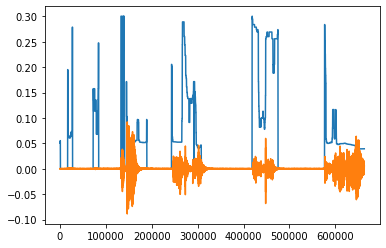

In [357]:
def reconstruct_waveform(speech_frames, waveform):
    z = torch.zeros(waveform.shape, dtype=waveform.dtype, device=waveform.device)

    # Convert to waveform
    n_frames = len(speech_frames)
    for i in range(n_frames):
        z[0, i*frame_size:(i+1)*frame_size] = speech_frames[i]
    
    # Extend with what was last detected
    z[0, n_frames*frame_size:] = speech_frames[-1]
    return z


# Convert frames into a waveform
z = reconstruct_waveform(freq, waveform)
z = z[0,:]

# Filter out non-voice sections
z[z>1000] = 0

plt.plot(.3*z/max(z))
plt.plot(waveform[0,:])
None

# [WIP] Using tril

In [142]:
lags = 400
frame_time = 10**-2
frame_size = int(math.ceil(sample_rate*frame_time))

w = waveform.view(-1)
waveform_length = waveform.size()[-1]
num_of_frames = math.ceil(waveform_length/frame_size)

# get lags
r = torch.nn.functional.pad(w, (0,lags)).repeat(lags)[...,:-lags].view(lags,-1)
r -= torch.tril(r, diagonal=-1, out=None)
r = r[...,lags:]

# pad to whole frames
pr = (1+r.shape[-1]//(lags*frame_size))*lags*frame_size - r.shape[-1]
pw = (1+w.shape[-1]//(lags*frame_size))*lags*frame_size - w.shape[-1]
r = torch.nn.functional.pad(r, (0, pr)).view(frame_size, -1, lags)
w0 = torch.nn.functional.pad(w, (0, pw)).view(frame_size, -1)

# truncate to whole frames
# r = r[...,:i].view(frame_size, -1, lags)
# w0 = w[...,:i].view(frame_size, -1)

r /= torch.norm(r, dim=0)
r /= torch.norm(w0)
r[torch.isnan(r)] = 0  # padding to whole frames causes division by zeros

r *= w0.view(*w0.shape, 1).repeat(1, 1, r.shape[-1])
r = r.sum(0)

# frames x lags
r.shape

torch.Size([800, 400])

In [143]:
r.shape

torch.Size([800, 400])

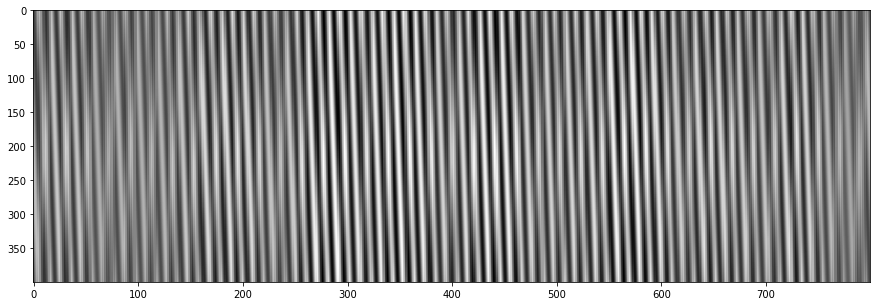

In [144]:
# correllograms

plt.figure(figsize=(15,5))
plt.imshow(r.t(), cmap="gray", aspect="auto")

In [145]:
560*frame_size

246960

In [146]:
r.shape

torch.Size([800, 400])

In [147]:
300000//frame_size

680

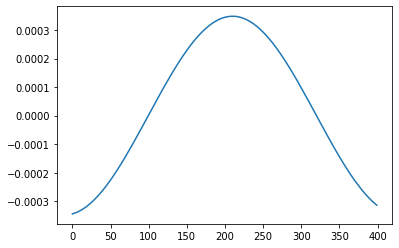

In [148]:
s = int(20*10**(-3))
plt.plot(r[s//frame_size,:])

In [149]:
r.argmax(dim=-1)

tensor([209, 251, 292, 333, 347, 368,   0,   0,  39, 164, 204, 206, 204, 246,
        345, 388, 399,  37,  78, 120, 161, 201, 243, 284, 325, 366,   0,   0,
         27, 145, 187, 199, 201, 242, 300, 343, 399,  26,  67, 107, 149, 190,
        231, 274, 314, 357,   0, 397,   0, 129, 169, 192, 211, 229, 248, 292,
        399,  21,  62, 104, 144, 187, 228, 270, 312, 354,   0, 362,   0, 239,
        260, 206, 221, 221, 182, 222, 399,  67, 104,  75, 116, 156, 199, 241,
        283, 324, 348, 353,   0, 389,   0, 163, 202, 195, 192, 223, 287, 331,
        399,  35,  77, 119, 159, 202, 244, 286, 329, 368,   0, 388,   0, 191,
        232, 215, 202, 240, 399,  15, 399,  60, 101, 144, 185, 226, 267, 308,
        350, 392,   0,  19,  61, 195, 233, 229, 226, 270, 391,   0, 399,  67,
        106, 149, 190, 230, 271, 313, 355, 394,   0,  17,  62, 179, 219, 228,
        230, 272, 349, 389, 399,  57,  96, 101, 142, 184, 226, 267, 307, 348,
        357, 397,   0,  60, 103, 173, 214, 223, 240, 281, 376, 3